# Lab 3 - Классификация на кривой доходности U.S. Treasury

В данной мы решаем задачу бинарной классификации: предсказать направление изменения доходности ставок на 10-летние облигации на следующий торговый день, 1 - вырастет, 0 - не вырастет. Используем два алгоритма, kNN и дерево решений - далее сравниваем их.

In [1]:
import os, glob, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay, classification_report, balanced_accuracy_score, matthews_corrcoef)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from IPython.display import display

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)

In [2]:
FRED_SERIES = {
    "3M":  "DGS3MO",
    "2Y":  "DGS2",
    "5Y":  "DGS5",
    "10Y": "DGS10",
    "30Y": "DGS30",
}

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# загрузка локальных данных, как в прошлых лабах
local_frames = []
date_candidates = ["observation_date", "observationDate", "observationdate", "DATE", "Date", "date"]
for label, sid in FRED_SERIES.items():
    fname = f"{sid}.csv"
    if not os.path.exists(fname):
        continue
    tmp = pd.read_csv(fname)
    date_col = next((c for c in date_candidates if c in tmp.columns), None)
    if date_col is None:
        continue
    val_col = sid if sid in tmp.columns else next((c for c in tmp.columns if c != date_col), None)
    tmp[val_col] = pd.to_numeric(tmp[val_col].replace('.', np.nan), errors='coerce')
    tmp[date_col] = pd.to_datetime(tmp[date_col])
    tmp = tmp.rename(columns={val_col: label})
    tmp = tmp.set_index(date_col)[[label]]
    tmp = tmp[~tmp.index.duplicated(keep='first')] 
    local_frames.append(tmp)

all_idx = None
for frame in local_frames:
    all_idx = frame.index if all_idx is None else all_idx.intersection(frame.index)
trimmed_frames = [f.reindex(all_idx) for f in local_frames]
df = pd.concat(trimmed_frames, axis=1, join='inner').sort_index().reset_index()
for cand in date_candidates:
    if cand in df.columns:
        df = df.rename(columns={cand: 'Date'})
        break
if 'Date' in df.columns:
    df = df.drop_duplicates(subset=['Date']).sort_values('Date').reset_index(drop=True)
df_raw = df.copy()
print("Колонки:", df.columns.tolist())
df.head()

Колонки: ['Date', '3M', '2Y', '5Y', '10Y', '30Y']


,Date,3M,2Y,5Y,10Y,30Y
0,1981-09-01,17.01,16.78,16.12,15.41,14.70
1,1981-09-02,16.65,16.78,16.09,15.40,14.70
2,1981-09-03,16.96,16.90,16.14,15.48,14.82
3,1981-09-04,16.64,16.89,16.17,15.51,14.84
4,1981-09-07,NaN,NaN,NaN,NaN,NaN


In [ ]:
def to_float(x):
    if isinstance(x, str) and x.strip() == ".":
        return np.nan
    return float(x)

df = df_raw.copy()
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"]).sort_values("Date").drop_duplicates(subset=["Date"]).reset_index(drop=True)

# все числовые — в float, точки в nan + сортировка по дате + удаление дублей
num_cols = [c for c in df.columns if c != "Date"]
for c in num_cols:
    df[c] = df[c].apply(to_float)

_df = df.set_index("Date")
_df = _df.dropna(how="all", subset=num_cols)
_df[num_cols] = _df[num_cols].ffill() # только вперёд!
_df = _df.dropna(how="any") #удаление остав9шихся пропусков
df = _df.reset_index()
print(df.info())
display(df.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11008 entries, 0 to 11007
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    11008 non-null  datetime64[ns]
 1   3M      11008 non-null  float64       
 2   2Y      11008 non-null  float64       
 3   5Y      11008 non-null  float64       
 4   10Y     11008 non-null  float64       
 5   30Y     11008 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 516.1 KB
None


,Date,3M,2Y,5Y,10Y,30Y
11003,2025-09-05,4.07,3.51,3.59,4.10,4.78
11004,2025-09-08,4.10,3.49,3.57,4.05,4.69
11005,2025-09-09,4.10,3.54,3.61,4.08,4.72
11006,2025-09-10,4.09,3.54,3.59,4.04,4.69
11007,2025-09-11,4.08,3.52,3.59,4.01,4.65


Сформируем несколько фич:
- d10y - дневное изменение доходности (как в второй лабораторной)
- slope_10y_3m - наклон кривой (спред 10лет - 3 месяца)
- but_2s10s30s - "бабочка": 30Y + 2Y - 2*10Y (раскрывает выпуклость кривой)
- mom_10y_5d - пятидневный моментум
- vol_10y_21d - 21-дневная волотильность

In [4]:
df_fe = df.copy()
df_fe["d10y"] = df_fe["10Y"].diff()
df_fe["slope_10y_3m"] = df_fe["10Y"] - df_fe["3M"]
df_fe["but_2s10s30s"] = df_fe["30Y"] + df_fe["2Y"] - 2.0 * df_fe["10Y"]
df_fe["mom_10y_5d"] = df_fe["10Y"].diff(5)
df_fe["vol_10y_21d"] = df_fe["10Y"].diff().rolling(21).std()

df_fe = df_fe.dropna().reset_index(drop=True)
display(df_fe.head())

,Date,3M,2Y,5Y,10Y,30Y,d10y,slope_10y_3m,but_2s10s30s,mom_10y_5d,vol_10y_21d
0,1981-10-01,15.33,16.57,16.13,15.75,15.14,-0.09,0.42,0.21,0.44,0.155321
1,1981-10-02,15.40,16.34,15.83,15.41,14.80,-0.34,0.01,0.32,-0.27,0.173709
2,1981-10-05,14.98,15.87,15.55,15.19,14.62,-0.22,0.21,0.11,-0.46,0.179094
3,1981-10-06,14.61,15.85,15.53,15.14,14.60,-0.05,0.53,0.17,-0.62,0.178967
4,1981-10-07,14.54,15.73,15.43,15.04,14.54,-0.10,0.50,0.19,-0.80,0.178367


Признаков: 10 -> ['3M', '2Y', '5Y', '10Y', '30Y', 'd10y', 'slope_10y_3m', 'but_2s10s30s', 'mom_10y_5d', 'vol_10y_21d']

Баланс классов (0=не выросла/упала, 1=выросла):


y_up_10y_next
0    5205
1    4912
Name: count, dtype: int64

y_up_10y_next
0    51.45
1    48.55
Name: proportion, dtype: float64

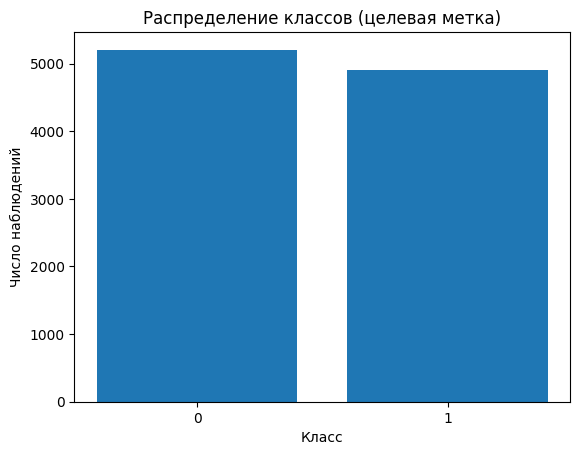

In [ ]:
df_clf = df_fe.copy()
# удалениее ничьих (т.е. если прогноз на то, что ничего не изменится) - иначе будет много шума
next_up = df_clf["10Y"].shift(-1) - df_clf["10Y"]
df_clf = df_clf.loc[next_up != 0].copy()
# метки на оставшихся индексах
df_clf["y_up_10y_next"] = (next_up.loc[df_clf.index] > 0).astype(int)

df_clf = df_clf.iloc[:-1, :].reset_index(drop=True)

target_col = "y_up_10y_next"
feature_cols = [c for c in df_clf.columns if c not in ["Date", target_col]]

print("Признаков:", len(feature_cols), "->", feature_cols)
print("\nБаланс классов (0=не выросла/упала, 1=выросла):")
display(df_clf[target_col].value_counts())
display((df_clf[target_col].value_counts(normalize=True)*100).round(2))

#визуализация баланса
counts = df_clf[target_col].value_counts().sort_index()
plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.title("Распределение классов (целевая метка)")
plt.xlabel("Класс")
plt.ylabel("Число наблюдений")
plt.show()

Как видно выше, баланс по классам примерно одинаковый.

Далее, чтоб не подглядывать в будуще (пару раз пришлось из-за этого переделывать), используем хронологическое разделение + TimeSeriesSplit в кросс‑валидации.

In [ ]:
N = len(df_clf)
split_idx = int(N*0.8)
train_idx = df_clf.index[:split_idx]
test_idx = df_clf.index[split_idx:]
X = df_clf[feature_cols].values
y = df_clf[target_col].values
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

print(f"Размеры обучающей и тестовой выборок: {X_train.shape} и {X_test.shape}")
# gap равен размеру окна волатильности, т.е. 21 день
tscv = TimeSeriesSplit(n_splits=5, gap=21)


Размеры обучающей и тестовой выборок: (8093, 10) и (2024, 10)


In [ ]:
# используем standardscaler, т.к. чтоб крупные признаки не так сильно доминировали
# подбираем родственников, веса, глубину.
# Скоринг в CV берем roc_auc

pipe_knn = Pipeline([
    ("scaler", StandardScaler()), # против утечки масштабов
    ("knn", KNeighborsClassifier())
])
param_grid_knn = {
    "knn__n_neighbors": [3, 5, 7, 9],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2] # 1- манхэтенское, 2 - евклидово
}

gs_knn = GridSearchCV( estimator=pipe_knn, param_grid=param_grid_knn, scoring="roc_auc", cv=tscv, n_jobs=-1, refit=True)
gs_knn.fit(X_train, y_train)

print("Лучшие параметры kNN:", gs_knn.best_params_)
print("Лучший ROC-AUC (CV):", round(gs_knn.best_score_, 4))

Лучшие параметры kNN: {'knn__n_neighbors': 3, 'knn__p': 2, 'knn__weights': 'distance'}
Лучший ROC-AUC (CV): 0.5047


In [ ]:
tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

param_grid_tree = {
    "max_depth": [3, 5, 7, 9, None],
    "min_samples_leaf": [1, 5, 10, 25],
    "min_samples_split": [2, 10, 25],
    "criterion": ["gini", "entropy", "log_loss"],
    "class_weight": [None, "balanced"], # balanced на всякий случай
    "ccp_alpha": [0.0, 0.0005, 0.001, 0.005], # на случай переобучения
}

gs_tree = GridSearchCV(estimator=tree, param_grid=param_grid_tree, scoring="roc_auc", cv=tscv, n_jobs=-1, refit=True)
gs_tree.fit(X_train, y_train)

print("Лучшие параметры дерева:", gs_tree.best_params_)
print("Лучший ROC-AUC (CV):", round(gs_tree.best_score_, 4))

Лучшие параметры дерева: {'ccp_alpha': 0.0005, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2}
Лучший ROC-AUC (CV): 0.5232


---------kNN (best)
Accuracy: 0.508893
Balanced Acc: 0.508825
MCC: 0.017668
Precision: 0.5099
Recall:    0.5320
F1:        0.5207
ROC-AUC:   0.5068

отчет о классификации:
              precision    recall  f1-score   support

   Down/Flat       0.51      0.49      0.50      1009
          Up       0.51      0.53      0.52      1015

    accuracy                           0.51      2024
   macro avg       0.51      0.51      0.51      2024
weighted avg       0.51      0.51      0.51      2024

---------Decision Tree (best)
Accuracy: 0.504941
Balanced Acc: 0.505513
MCC: 0.011955
Precision: 0.5105
Recall:    0.3123
F1:        0.3875
ROC-AUC:   0.5060

отчет о классификации:
              precision    recall  f1-score   support

   Down/Flat       0.50      0.70      0.58      1009
          Up       0.51      0.31      0.39      1015

    accuracy                           0.50      2024
   macro avg       0.51      0.51      0.49      2024
weighted avg       0.51      0.50      0.49    

<Figure size 640x480 with 0 Axes>

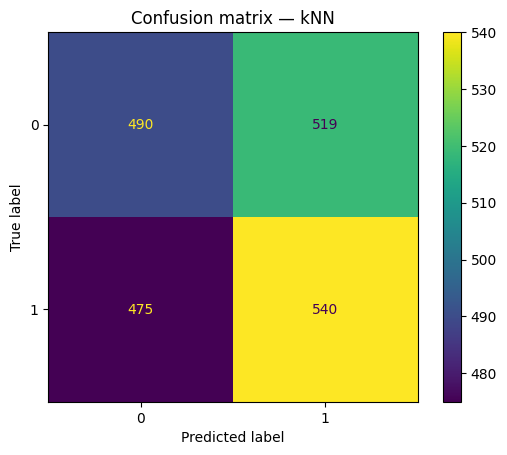

<Figure size 640x480 with 0 Axes>

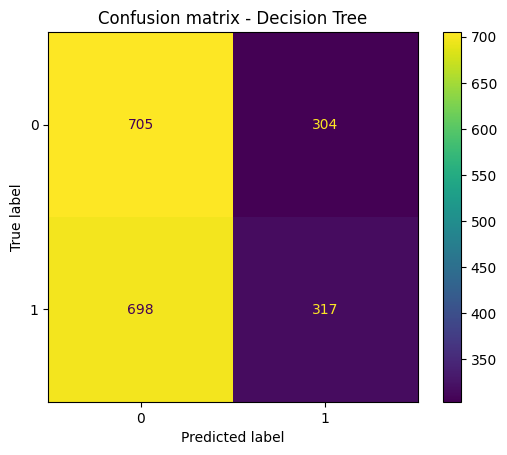

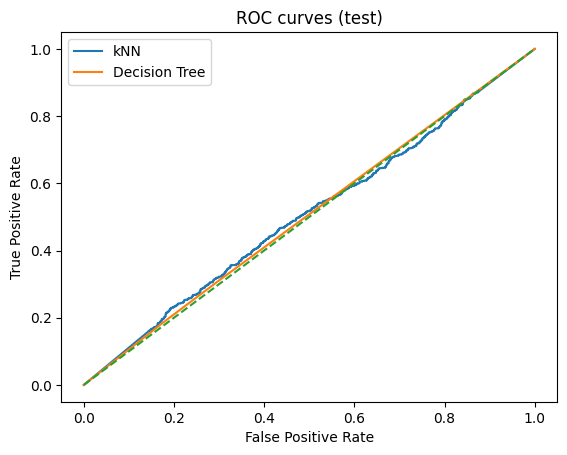

,model,accuracy,balanced_accuracy,mcc,precision,recall,f1,roc_auc
0,kNN (best),0.508893,0.508825,0.017668,0.509915,0.532020,0.520733,0.506817
1,Decision Tree (best),0.504941,0.505513,0.011955,0.510467,0.312315,0.387531,0.506029


In [ ]:
def evaluate_model(name, fitted, X_test, y_test, proba_method="predict_proba"):
    y_pred = fitted.predict(X_test)
    if hasattr(fitted, proba_method):
        y_score = getattr(fitted, proba_method)(X_test)
        if isinstance(y_score, np.ndarray) and y_score.ndim == 2:
            y_score = y_score[:, 1]
    else:
        y_score = None

    # accuracy - доля верных предсказаний
    # balanced Accuracy - (TPR + TNR)/2, будет полезно при дисбалансе
    # precision/recall/F1 - качество по положительному классу
    # ROC-AUC - способность ранжировать
    # MCC - корреляция предсказаний и истинных меток, устойчива к дисбалансу
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_score) if y_score is not None else np.nan

    print(f"---------{name}")
    print(f"Accuracy: {acc:4f}")
    print(f"Balanced Acc: {bal_acc:4f}")
    print(f"MCC: {mcc:4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1:        {f1:.4f}")
    print(f"ROC-AUC:   {roc:.4f}")
    print("\nотчет о классификации:")
    print(classification_report(y_test, y_pred, target_names=['Down/Flat', 'Up']))
    return {"model": name, "accuracy": acc, "balanced_accuracy": bal_acc, "mcc": mcc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": roc}, y_pred, y_score

# оценка
res_knn, y_pred_knn, y_score_knn = evaluate_model("kNN (best)", gs_knn.best_estimator_, X_test, y_test)
res_tree, y_pred_tree, y_score_tree = evaluate_model("Decision Tree (best)", gs_tree.best_estimator_, X_test, y_test)

fig = plt.figure()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn)
plt.title("Confusion matrix — kNN")
plt.show()

fig = plt.figure()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tree)
plt.title("Confusion matrix - Decision Tree")
plt.show()

plt.figure()
if y_score_knn is not None and not np.isnan(y_score_knn).any():
    fpr_knn, tpr_knn, _ = roc_curve(y_test, y_score_knn)
    plt.plot(fpr_knn, tpr_knn, label="kNN")
if y_score_tree is not None and not np.isnan(y_score_tree).any():
    fpr_tree, tpr_tree, _ = roc_curve(y_test, y_score_tree)
    plt.plot(fpr_tree, tpr_tree, label="Decision Tree")

plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves (test)")
plt.legend()
plt.show()

results_df = pd.DataFrame([res_knn, res_tree])
results_df

,feature,importance
7,but_2s10s30s,0.207892
0,3M,0.193923
5,d10y,0.189428
8,mom_10y_5d,0.156979
6,slope_10y_3m,0.139031
9,vol_10y_21d,0.112747
1,2Y,0.000000
4,30Y,0.000000
2,5Y,0.000000
3,10Y,0.000000


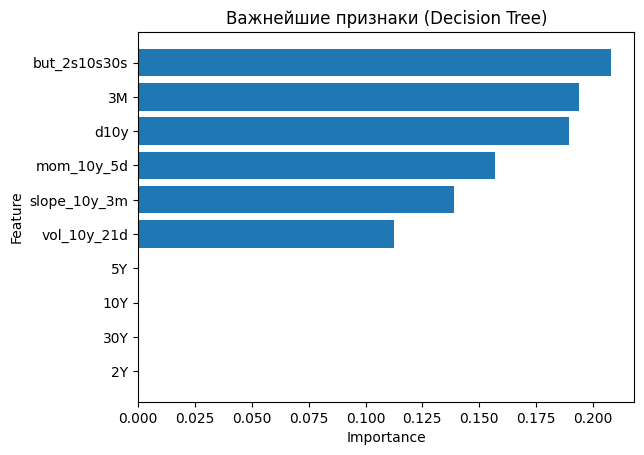

In [10]:
best_tree = gs_tree.best_estimator_
importances = best_tree.feature_importances_
names = feature_cols

if importances is not None:
    imp = pd.DataFrame({"feature": names, "importance": importances}).sort_values("importance", ascending=False)
    display(imp.head(20))

    plt.figure()
    top=imp.head(15).sort_values("importance")
    plt.barh(top["feature"], top["importance"])
    plt.title("Важнейшие признаки (Decision Tree)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
else:
    print("Не удалось извлечь важности признаков.")


# Вывод
- kNN (best): Accuracy 0.5089, Balanced Acc 0.5088, Precision 0.5099, Recall 0.5320, F1 0.5207, ROC‑AUC 0.5068.
- Decision Tree (best): Accuracy 0.5049, Balanced Acc 0.5055, Precision 0.5105, Recall 0.3123, F1 0.3875, ROC‑AUC 0.5060.

Матрицы ошибок показывают, что kNN чаще показывает класс 1 (при этом больше ложных срабатываний на 0), то-есть kNN более "бычий". Дерево же - консервативнее, больше предсказывает "медвежий" сценарий. ROC-кривые близки к диагонали - соответствует точности в 0.5.

Выше показан топ важности по признакам, 5Y/.../2Y - не входили в разбиение, поэтому важность 0 (вероятно, это нормально для деревьев при коллинейрности).

Качество моделей около случайного уровня. Это ожидаемо для прогноза направления на +1 день (крайне небольшой срок). Доля объяснимой вариации довольно низкая, а признаки отражают в большей степени форму кривой и локальную волатильность, что будет работать лучше на более больших таймфреймах.

Для улучшения качества можно добавить более богатые фичи (позиции на фьючерсах, календарная сезонность и т.д.) + увеличить горизонт предсказания.